In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as npimg 
import numpy as np
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import glob
import matplotlib.patches as patches
from scipy import signal as sg
from utils import *
%matplotlib inline

In [8]:
# Define a class to receive the characteristics of each line detection
from collections import deque
class Line():
    def __init__(self):
        
        # If we didn't see the line last frame, then we're more accepting of new lines
        self.detected = False  
        #polynomial coefficients for the incoming fit
        self.current_fit = [np.array([False])]  
        # x values of the line 
        self.fit_buffer = deque(maxlen = 10)
        # Polynomial coefficients averaged
        self.average_fit = None  
        # Average x values of the fitted line
        self.averagex = None     

        # Radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base = None 
        
        # Convert pixel to meters. Don't change over time.
        self.ym_per_pix = 30/300 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/300 # meters per pixel in x dimension
        self.ploty = np.linspace(0, 599, num=600)
        self.y_eval = np.max(self.ploty)

        
    def add_line(self, new_fit):
        if new_fit != None:
            if self.seems_reasonable(new_fit):                
                self.current_fit = new_fit
                self.recalculate()   
        else: 
            self.detected = False
        
    def seems_reasonable(self, new_fit):
        
        if len(self.fit_buffer) < 10:
            return True

        if (.0004 > new_fit[0]) & (-.0004 < new_fit[0]):
            if ((self.average_fit[2]+40>new_fit[2]) & (self.average_fit[2]-50 < new_fit[2])):
                return True
        
        
        return False
    
    
    def recalculate(self):
        self.fit_buffer.append(self.current_fit)
        self.calc_average_fit()
        self.calc_averagex()
        
        self.calc_radius_of_curvature()            
        
    def calc_average_fit(self):
        self.average_fit = np.mean(self.fit_buffer, 0)
        
    def calc_averagex(self):
        f = self.average_fit
        self.averagex = f[0]*self.ploty**2 + f[1]*self.ploty + f[2]
    
    def calc_radius_of_curvature(self):
        # multiply pixels by meters/pixel to get meters
        fit_cr = np.polyfit(
            self.averagex * self.xm_per_pix,
            self.ploty    * self.ym_per_pix, 2)
        
        self.radius_of_curvature = ((
            1 + ( 2 * fit_cr[0] * self.y_eval * self.ym_per_pix
                 + fit_cr[1])**2 )**1.5 ) / np.absolute(2 * fit_cr[0])
        
    def get_averagex(self):
        return self.averagex
    def get_average_fit(self):
        return self.average_fit
    def get_radius_of_curvature(self):
        return self.radius_of_curvature  

In [9]:
leftline = Line()
rightline = Line()
def lane_detector(original_image):
    
    undistorted_image = undistort(original_image)
    birdseye = first2bird(undistorted_image)
    warped = binarify(birdseye)
    lane_lines, left_fit, right_fit = blindlanefinder(warped)
    
    leftline.add_line(left_fit)
    rightline.add_line(right_fit)
    
    lanecurve = average_curve(rightline.get_radius_of_curvature(), leftline.get_radius_of_curvature())
    
    lfit = leftline.get_average_fit()
    rfit = rightline.get_average_fit()
    offcenter = measure_center(lfit, rfit) 
    
    
    laned_image = drawlane(leftline.get_average_fit(), rightline.get_average_fit(), undistorted_image)
    cv2.putText(laned_image, str(round(offcenter[0], 3))+"m to the "+offcenter[1], (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    cv2.putText(laned_image, str(round(lanecurve))+"m curve", (10,80), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
    
    return laned_image

## Video

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
vid_output = 'project_video_out.mp4'
clip = VideoFileClip('./project_video.mp4')
vid_clip = clip.fl_image(lambda x: lane_detector(x))
vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [02:22<00:00,  9.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [12]:
vid_output = './project_video_out.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

## Pipeline explained

In [7]:
original_image = load_image('data/test_images/test5.jpg')
image = undistort(original_image)

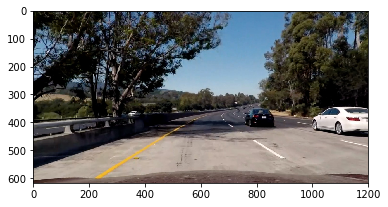

In [8]:
plt.imshow(image)
plt.show()

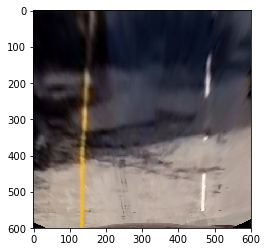

In [9]:
bird = first2bird(image)
plt.imshow(bird)
plt.show()

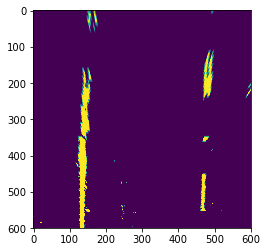

In [10]:
warped = first2bird(binarify(image))
plt.imshow(warped)
plt.show()

In [11]:
lane_lines, left_fit, right_fit = blindlanefinder(warped)

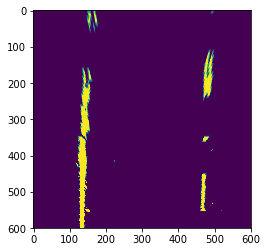

In [12]:
plt.imshow(lane_lines)
plt.show()

In [13]:
ploty = np.linspace(0, 599, num=600)
leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
rightx = (left_fit[0])*ploty**2 + (left_fit[1]+.1)*ploty + (left_fit[2]+.1)

In [14]:
abs(leftx - rightx)

array([  0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,   0.9,
         1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,   1.8,
         1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,
         3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,   4.4,   4.5,
         4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,   5.3,   5.4,
         5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.1,   6.2,   6.3,
         6.4,   6.5,   6.6,   6.7,   6.8,   6.9,   7. ,   7.1,   7.2,
         7.3,   7.4,   7.5,   7.6,   7.7,   7.8,   7.9,   8. ,   8.1,
         8.2,   8.3,   8.4,   8.5,   8.6,   8.7,   8.8,   8.9,   9. ,
         9.1,   9.2,   9.3,   9.4,   9.5,   9.6,   9.7,   9.8,   9.9,
        10. ,  10.1,  10.2,  10.3,  10.4,  10.5,  10.6,  10.7,  10.8,
        10.9,  11. ,  11.1,  11.2,  11.3,  11.4,  11.5,  11.6,  11.7,
        11.8,  11.9,  12. ,  12.1,  12.2,  12.3,  12.4,  12.5,  12.6,
        12.7,  12.8,

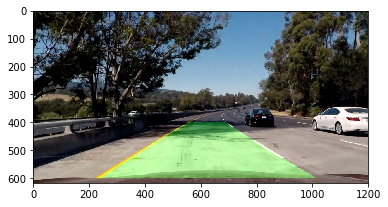

In [15]:
plt.imshow(drawlane(left_fit, right_fit, image))
plt.show()

## White

In [16]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

In [17]:
hsv2 = (185, 255)
hsv1 = (0, 25)
lab0 = (185, 255)

In [18]:
white_hsv2 = thresh_binary(hsv[:,:,2], hsv2)
white_hsv1 = thresh_binary(hsv[:,:,1], hsv1)
white_lab0 = thresh_binary(lab[:,:,0], lab0)

In [19]:
white = np.zeros_like(image)
white[(white_lab0>0)&(white_hsv1>0)&(white_hsv2>0)] = 255

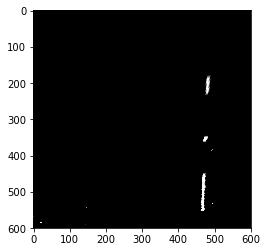

In [20]:
plt.imshow(first2bird(white), cmap='gray')
plt.show()

## Yellow

In [21]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

In [22]:
hsv0 = (17, 30)
lab2 = (148, 255)

In [23]:
yellow_hsv0 = thresh_binary(hsv[:,:,0], hsv0)
yellow_lab2 = thresh_binary(lab[:,:,2], lab2)

In [24]:
yellow = np.zeros_like(image)
yellow[(yellow_lab2>0)&(yellow_hsv0>0)] = 255 #

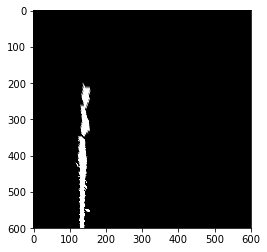

In [25]:
plt.imshow(first2bird(yellow), cmap='gray')
plt.show()

## Sobel X

In [26]:
sobelx_binary = thresh_binary(sobelx, thresh=(30, 255))
plt.imshow(first2bird(sobelx_binary), cmap='gray')
plt.show()

NameError: name 'sobelx' is not defined

## Combined

In [ ]:
yellow_binary = cv2.cvtColor(yellow, cv2.COLOR_RGB2GRAY)
white_binary  = cv2.cvtColor(white, cv2.COLOR_RGB2GRAY)

In [ ]:
sobelx = sobel_image(image, orient='x')
sobelx_binary = thresh_binary(sobelx, thresh=(20, 255))

In [ ]:
combined = np.zeros_like(sobelx_binary)
combined[(yellow_binary>0)|(white_binary>0)|(sobelx_binary>0)] = 255 #

In [ ]:
plt.imshow(first2bird(combined), cmap='gray')
plt.show()